This notebook is for testing portfolio creation methods   

Check does pyportfolio opt use yearly returns   
drop any which have negative returns   

we have a problem which creeps in as we increase the # of input columns investigationg if this is due to anomalies in some columns of is just a result of taking in so many columns.
- *The covariance matrix is non positive semidefinite. Amending eigenvalues. Could not fix matrix. Please try a different risk model.*
- Issue is around rows to column ratio see issue on [PyPortfolioOpt #263](https://github.com/robertmartin8/PyPortfolioOpt/issues/263)


Currently working on a function that calculates an optimal sharpe portfolio & tests its performance on the following year(always test on a 1 year period but can use multiple years of data for input)   

**Inputs:**
- closing price Database *DataFrame*
- startdate *yyyy-mm-dd*
- enddate *yyyy-mm-dd*  

**Outputs** (Array)
- startdate *yyyy-mm-dd*
- enddate *yyyy-mm-dd*
- NOT RELEVANT years of input data (ie Years(enddate-startdate)) *float*
- optimal portfolio Expected performance *float*
- optimal portfolio Actual performance *float*
- performance of the market (ie total change of the input markets value over the test year) *float*


Do some expected returns histograms to visualise


In [94]:
#Import the libraries
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import math
from datetime import timedelta 
import operator
from functools import reduce
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import cvxpy as cp
from joblib import Parallel, delayed
import seaborn as sns
pd.options.mode.chained_assignment = None #silences setting with a copy warning
import DatabaseMainFnc as dmf
pd.set_option('display.max_columns', 38)
#plt.rcParams['figure.figsize'] = [10, 10]


In [95]:
dmf.net_gains(3000,0.70,5,people=2)

30285.1081406409

In [96]:
%%time
df_Nasdaq=dmf.connectAndLoadDb('NASDAQ')
df_Nasdaq=df_Nasdaq.set_index(pd.DatetimeIndex(df_Nasdaq['Date'].values))
df_Nasdaq.drop(columns=['Date'],axis=1, inplace=True)

df_NYSE=dmf.connectAndLoadDb('NYSE')
df_NYSE=df_NYSE.set_index(pd.DatetimeIndex(df_NYSE['Date'].values))
df_NYSE.drop(columns=['Date'],axis=1, inplace=True)
df_Nasdaq.tail(10)

Connecting database:NASDAQ
Database connected!
Connecting database:NYSE
Database connected!
Wall time: 6.65 s


,AACG,AACQ,AACQU,AAL,AAME,AAOI,AAON,AAPL,AAWW,AAXJ,ABCB,ABCL,ABCM,ABEO,ABGI,ABIO,ABMD,ABNB,ABST,...,ZIONO,ZIONP,ZIOP,ZIXI,ZKIN,ZLAB,ZM,ZNGA,ZNTE,ZNTEU,ZNTEW,ZNTL,ZS,ZSAN,ZUMZ,ZVO,ZWRKU,ZYNE,ZYXI
2006-01-03,NaN,NaN,NaN,35.305672,2.605994,NaN,3.032772,2.287095,44.50,NaN,16.125223,NaN,NaN,127.5,NaN,128973.601562,9.35,NaN,NaN,...,NaN,NaN,3.60,1.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.325001,NaN,NaN,NaN,0.217625
2006-01-04,NaN,NaN,NaN,36.955460,2.504342,NaN,3.024436,2.293826,45.00,NaN,16.247938,NaN,NaN,117.5,NaN,136231.203125,9.62,NaN,NaN,...,NaN,NaN,4.00,2.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.299999,NaN,NaN,NaN,0.244828
2006-01-05,NaN,NaN,NaN,37.436264,2.458137,NaN,3.037774,2.275774,44.50,NaN,16.460653,NaN,NaN,115.0,NaN,191570.406250,9.55,NaN,NaN,...,NaN,NaN,4.00,2.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.434999,NaN,NaN,NaN,0.212184
2006-01-06,NaN,NaN,NaN,36.766911,2.458137,NaN,3.017767,2.334520,44.25,NaN,16.501554,NaN,NaN,112.5,NaN,195804.000000,9.75,NaN,NaN,...,NaN,NaN,4.25,2.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.430000,NaN,NaN,NaN,0.212184
2006-01-09,NaN,NaN,NaN,36.399246,2.467378,NaN,3.076122,2.326870,44.00,NaN,16.714266,NaN,NaN,107.5,NaN,215308.796875,10.15,NaN,NaN,...,NaN,NaN,4.25,2.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.830000,NaN,NaN,NaN,0.217625
2006-01-10,NaN,NaN,NaN,35.635624,2.458137,NaN,3.084458,2.474040,43.75,NaN,17.041510,NaN,NaN,115.0,NaN,236174.406250,10.21,NaN,NaN,...,NaN,NaN,4.25,2.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.410000,NaN,NaN,NaN,0.217625
2006-01-11,NaN,NaN,NaN,32.807411,2.458137,NaN,3.056115,2.567054,43.75,NaN,16.771534,NaN,NaN,125.0,NaN,224834.406250,10.55,NaN,NaN,...,NaN,NaN,4.25,2.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.139999,NaN,NaN,NaN,0.212184
2006-01-12,NaN,NaN,NaN,32.986534,2.559788,NaN,3.034441,2.578987,44.00,NaN,16.820625,NaN,NaN,120.0,NaN,229521.593750,10.71,NaN,NaN,...,NaN,NaN,4.25,1.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.650000,NaN,NaN,NaN,0.217625
2006-01-13,NaN,NaN,NaN,32.100349,2.578271,NaN,3.076122,2.618762,45.75,NaN,16.836987,NaN,NaN,110.0,NaN,233150.406250,10.27,NaN,NaN,...,NaN,NaN,4.25,2.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.840000,NaN,NaN,NaN,0.217625
2006-01-17,NaN,NaN,NaN,28.282246,2.458137,NaN,3.042776,2.591837,45.00,NaN,16.763355,NaN,NaN,107.5,NaN,226346.406250,9.90,NaN,NaN,...,NaN,NaN,4.35,1.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.985001,NaN,NaN,NaN,0.228506


In [164]:
def portfolio_generate_test(database,startdate,enddate, silent=True):
    print('Running for :'+str(startdate)+' to '+str(enddate))
    # Subset for date range
    df_input=database[startdate:enddate]
    if silent == False:
        print ("Initial number of stocks: "+str(len(df_input.columns)))

    #Check for stocks which are too expensive for us to buy & drop those
    p_max=400
    p_now=database.iloc[-1,:]
    df_unaffordable=p_now[p_now>p_max] #we can set max price here maybe as an optional
    l_unaffordable=df_unaffordable.index.tolist()
    df_input.drop(columns=l_unaffordable, inplace=True)
    if silent == False:
        print ("-----------------------------------------------------")
        print ("Our max price is : €"+str(p_max))
        print ("Number of stocks to drop due being unnaffordble: "+str(len(l_unaffordable)))
        print ("Number of stocks remaining: "+str(len(df_input.columns)))


    # drop any columns with more than half or more Nas as the models dont like these
    half_length=int(len(df_input)*0.50)
    l_drop=df_input.columns[df_input.iloc[:half_length,:].isna().all()].tolist()
    df_input.drop(columns=l_drop, inplace=True)
    if silent == False:
        print ("-----------------------------------------------------")
        print ("Number of stocks due to NAs: "+str(len(l_drop)))
        print ("Number of stocks remaining: "+str(len(df_input.columns)))

    # drop any columns with more  Nas for their last 5 rows as these have been delisted
    l_drop=df_input.columns[df_input.iloc[-5:,:].isna().all()].tolist()
    df_input.drop(columns=l_drop, inplace=True)
    if silent == False:
        print ("-----------------------------------------------------")
        print ("Number of stocks due to being delisted: "+str(len(l_drop)))
        print ("Number of stocks remaining: "+str(len(df_input.columns)))


    #see which stocks have negative returns or low returns in the period & drop those
    df_pct=((df_input.iloc[-1,:] / df_input.iloc[0,:])-1).fillna(-1.0)
    df_pct=df_pct[df_pct<=0] #we can set minimum returns here maybe as an optional
    l_pct=df_pct.index.tolist()
    df_input.drop(columns=l_pct, inplace=True)
    if silent == False:
        print ("-----------------------------------------------------")
        print ("Number of stocks due to Negative returns: "+str(len(l_pct)))
        print ("Number of stocks remaining: "+str(len(df_input.columns)))
        print ("Number of days data: "+str(len(df_input)))
        print ("We will only keep the top 200 performing stocks when creating our portfolio(Vary this in testing)")

    #We will only keep the 200  best performing assets can make this an optional input
    df=df_input
    mu = expected_returns.mean_historical_return(df)
    top_stocks = mu.sort_values(ascending=False).index[:250]
    df = df[top_stocks]

    #Calculate expected annulised returns & annual sample covariance matrix of the daily asset
    mu = expected_returns.mean_historical_return(df)
    S = risk_models.sample_cov(df)

    # Optomise for maximal Sharpe ratio
    ef= EfficientFrontier(mu, S) #Create the Efficient Frontier Object

    #We can try a variety of objectives 
    weights = ef.max_sharpe()
    #weights = ef.min_volatility()
    #weights = ef.efficient_risk(target_volatility)
    #target_return=0.2
    #weights = ef.efficient_return(target_return)


    cl_weights= ef.clean_weights()
    #print(cl_weights)
    if silent == False:
        print("-------------------------------------------------------------")
        print("Our Benchmark portfolio the S&P 500 has: Volatility  18.1% & Annual Return: 10.6%")
        ef.portfolio_performance(verbose=True)
    expected_portfolio_returns=ef.portfolio_performance()[0]

    #calculates the actual performance date range 
    actual_startdate = pd.to_datetime(enddate) + pd.DateOffset(days=1)
    actual_enddate = pd.to_datetime(actual_startdate) + pd.DateOffset(years=1)

    df_actual=database[actual_startdate:actual_enddate]
    df_actual=df_actual[top_stocks]
    df_aclpct=(df_actual.iloc[-1,:] / df_actual.iloc[0,:])-1
    actual_returns=sum(df_aclpct[ticker]*cl_weights[ticker] for ticker in cl_weights)
    if silent == False:
        print("-------------------------------------------------------------")
        print("Our portfolio performed at : " + str(np.round(actual_returns,3)*100)+"%")

    return [pd.to_datetime(startdate),pd.to_datetime(enddate),expected_portfolio_returns,actual_returns]

In [165]:
%%time
database=df_Nasdaq
startdate=pd.to_datetime("2016-01-01")
enddate=pd.to_datetime("2020-01-01")
a_test=[]
t_start=startdate
t_end=enddate

while t_start + pd.DateOffset(years=1) <= t_end:
    a_test.append(portfolio_generate_test(database,t_start,t_end))
    t_start=t_start + pd.DateOffset(months=1)
    if t_start + pd.DateOffset(years=1) == t_end:
        t_start=startdate
        t_end=t_end - pd.DateOffset(months=1)
df_test=pd.DataFrame(a_test,columns=['Start_Date','End_date','Expected_returns','Actual_returns'])

0:00:00 to 2019-03-01 00:00:00
Running for :2016-02-01 00:00:00 to 2019-03-01 00:00:00
Running for :2016-03-01 00:00:00 to 2019-03-01 00:00:00
Running for :2016-04-01 00:00:00 to 2019-03-01 00:00:00
Running for :2016-05-01 00:00:00 to 2019-03-01 00:00:00
Running for :2016-06-01 00:00:00 to 2019-03-01 00:00:00
Running for :2016-07-01 00:00:00 to 2019-03-01 00:00:00
Running for :2016-08-01 00:00:00 to 2019-03-01 00:00:00
Running for :2016-09-01 00:00:00 to 2019-03-01 00:00:00
Running for :2016-10-01 00:00:00 to 2019-03-01 00:00:00
Running for :2016-11-01 00:00:00 to 2019-03-01 00:00:00
Running for :2016-12-01 00:00:00 to 2019-03-01 00:00:00
Running for :2017-01-01 00:00:00 to 2019-03-01 00:00:00
Running for :2017-02-01 00:00:00 to 2019-03-01 00:00:00
Running for :2017-03-01 00:00:00 to 2019-03-01 00:00:00
Running for :2017-04-01 00:00:00 to 2019-03-01 00:00:00
Running for :2017-05-01 00:00:00 to 2019-03-01 00:00:00
Running for :2017-06-01 00:00:00 to 2019-03-01 00:00:00
Running for :2017

(-1, 4)

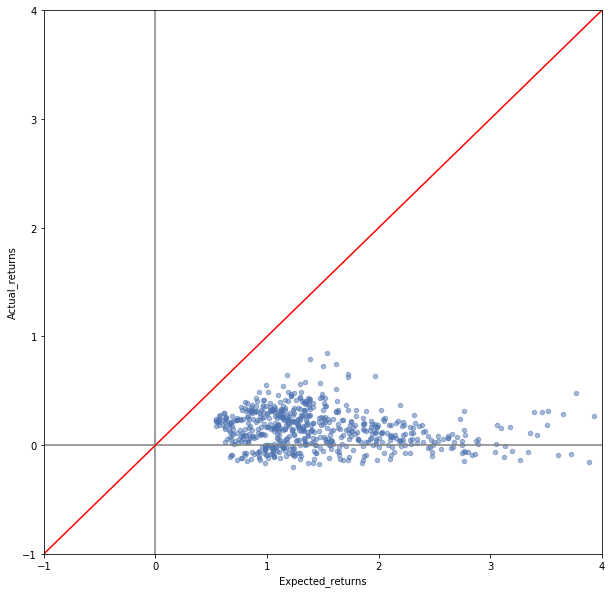

In [166]:
# Plot expected vs actual scatter
import matplotlib.lines as mlines
ax1 = df_test.plot.scatter(x='Expected_returns', y='Actual_returns',alpha=0.5)
line = mlines.Line2D([0, 1], [0, 1], color='red')
plt.axhline(0,color='gray') # x = 0
plt.axvline(0,color='gray') # y = 0
transform = ax1.transAxes
line.set_transform(transform)
ax1.add_line(line)
ax1.set_xlim([-1, 4])
ax1.set_ylim([-1, 4])

0.14626782534710178

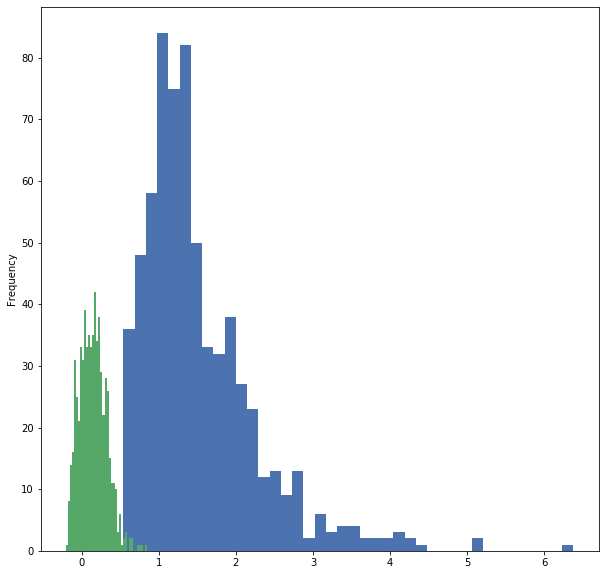

In [172]:
#plot epected vs actual returns
df_test.Expected_returns.plot.hist(bins=40)
df_test.Actual_returns.plot.hist(bins=40)
df_test.Actual_returns.mean()

In [26]:
# Get the discrete allocation of each share per stock notused
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

portfolio_val = 3000
latest_prices=get_latest_prices(df)
weights=cl_weights
da=DiscreteAllocation(weights,latest_prices,total_portfolio_value=portfolio_val)
allocation, leftover = da.lp_portfolio()

print('Discrete allocation  :', allocation)
print('Funds Remaining:', leftover)

Discrete allocation  : {'ZYXI': 9, 'PAYS': 5, 'ARGX': 1, 'AMRN': 1, 'GRVY': 1, 'RCM': 2, 'CZR': 2, 'KRMD': 9, 'TCMD': 1, 'KNSL': 3, 'CGC': 1, 'CWST': 4, 'THTX': 10, 'BLFS': 1, 'CELH': 5, 'HLNE': 1, 'HLG': 2, 'CODA': 1, 'PDEX': 5, 'LMST': 5, 'TWNKW': 4, 'NYMX': 3, 'AUDC': 1, 'DYAI': 5, 'RSSS': 17, 'FSV': 1, 'ASPU': 3, 'FSBW': 3, 'SSRM': 5, 'FORTY': 1, 'ATLC': 3, 'TAIT': 3, 'FCAP': 1, 'BFC': 3, 'MMAC': 8, 'PLBC': 3, 'FVCB': 6, 'FDBC': 1, 'BRID': 1}
Funds Remaining: 0.3722567558288574
